In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

!pip install spectral
import spectral

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import tensorflow

In [ ]:
def loadDataSet(name):
    if name == 'IP':
        img = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
        gt = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
        labels = [
                  'unknown',
                  'Alfalfa', 
                  'Corn-notill', 
                  'Corn-mintill', 
                  'Corn',
                  'Grass-pasture', 
                  'Grass-trees', 
                  'Grass-pasture-mowed', 
                  'Hay-windrowed', 
                  'Oats', 
                  'Soybean-notill', 
                  'Soybean-mintill',
                  'Soybean-clean', 
                  'Wheat', 
                  'Woods', 
                  'Buildings-Grass-Trees-Drives',
                  'Stone-Steel-Towers'
                  ]
        rgb_bands = (29, 19, 9)
        spatial_resolution = 20 

    elif name == 'SAL':
        img = sio.loadmat('Salinas_corrected.mat')['salinas_corrected']
        gt = sio.loadmat('Salinas_gt.mat')['salinas_gt']
        labels = [
                  "unknown",
                  "Brocoli_green_weeds_1", 
                  "Brocoli_green_weeds_2",
			            "Fallow", 
                  "Fallow_rough_plow", 
                  "Fallow_smooth", 
                  "Stubble",
			            "Celery", 
                  "Grapes_untrained", 
                  "Soil_vinyard_develop", 
                  "Corn_senesced_green_weeds",
			            "Lettuce_romaine_4wk", 
                  "Lettuce_romaine_5wk", 
                  "Lettuce_romaine_6wk", 
                  "Lettuce_romaine_7wk",
			            "Vinyard_untrained", 
                  "Vinyard_vertical_trellis",
                  ]
        rgb_bands = (29, 19, 9)
        spatial_resolution = 3.7 

    elif name == 'PU':
        img = sio.loadmat('PaviaU.mat')['paviaU']
        gt = sio.loadmat('PaviaU_gt.mat')['paviaU_gt']
        labels = [
                  "unknown",
                  "Asphalt", 
                  "Meadows", 
                  "Gravel", 
                  "Trees", 
                  "Painted metal sheets",
			            "Bare Soil", 
                  "Bitumen", 
                  "Self-Blocking Bricks", 
                  "Shadows",
                  ]
        rgb_bands = (53,31,8)
        spatial_resolution = 1.3

    elif name == 'KSC': 
        img = sio.loadmat("KSC.mat")["KSC"]
        gt = sio.loadmat("KSC_gt.mat")["KSC_gt"]
        labels = [
                  "Undefined", 
                  "Scrub", 
                  "Willow swamp", 
                  "Cabbage palm/hammock", 
                  "Cabbage palm/oak hammock", 
                  "Slash pine", 
                  "Oak/broadleaf hammock", 
                  "Hardwood swamp", 
                  "Graminoid marsh", 
                  "Spartina marsh", 
                  "Cattail marsh", 
                  "Salt marsh",
                  "Mud flats", 
                  "Water",
                  ]
        rgb_bands = (29, 19, 9)
        spatial_resolution = 18

    elif name == 'BOT': 
        img = sio.loadmat("Botswana.mat")["Botswana"]
        gt = sio.loadmat("Botswana_gt.mat")["Botswana_gt"]
        labels = [
            "Undefined",
            "Water",
            "Hippo grass",
            "Floodplain grasses 1",
            "Floodplain grasses 2",
            "Reeds",
            "Riparian",
            "Firescar",
            "Island interior",
            "Acacia woodlands",
            "Acacia shrublands",
            "Acacia grasslands",
            "Short mopane",
            "Mixed mopane",
            "Exposed soils",
        ]
        rgb_bands = (75, 33, 20)
        spatial_resolution = 30

    else:
      print(name + " Dataset is not defined in the function. Please ensure the name is correct or if the loading is defined") 
      return None, None, None, None, None

    return img, gt, labels, rgb_bands, spatial_resolution

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def applyScaling(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    sc = MinMaxScaler()
    newX = sc.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], X.shape[2]))
    return newX, sc

In [ ]:
def padWithZeros(X, PATCH_SIZE=5):
    margin = int((PATCH_SIZE - 1) / 2)
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X    
    return newX

In [ ]:
def createPatches(X, y, PATCH_SIZE=5, removeZeroLabels = True):
    margin = int((PATCH_SIZE - 1) / 2)
    zeroPaddedX = padWithZeros(X, PATCH_SIZE)
    
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], PATCH_SIZE, PATCH_SIZE, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0

    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1

    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
        
    return patchesData, patchesLabels

In [ ]:
def getIndices(X, y, PATCH_SIZE=5, removeZeroLabels = True, writeToFile=False):
    margin = int((PATCH_SIZE - 1) / 2)
    patchIndexes = []

    for r in range(margin, X.shape[0] - margin):
        for c in range(margin, X.shape[1] - margin):
            patchIndexes.append([(r,c), [(r - margin,r + margin + 1), (c - margin,c + margin + 1)], gt[r-margin, c-margin]])
    
    if removeZeroLabels:
        patchIndexes = [index for index in patchIndexes if index[2] > 0]
    
    if writeToFile:
        with open('indexes.txt', 'w') as f:
            f.write("Remove Zero Labels : {}\n".format(removeZeroLabels))
            for item in patchIndexes:
                f.write("Index : {}, patchIndex: {}, Label : {}\n".format(item[0], item[1], item[2]))

    indices = []
    labels = []
    for item in patchIndexes:
      indices.append(item[0])
      labels.append(item[2])

    return indices, labels

In [ ]:
import math
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, img, gt, n_classes, indices, patch_size, batch_size=32, shuffle=True):
        self.image = img
        self.patch_size = patch_size
        self.margin = int((self.patch_size - 1) / 2)
        self.gt = gt
        self.n_classes = n_classes
        self.indices = indices
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    # Get the number of batches
    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    # Generate one Batch of Data
    def __getitem__(self, index):
        batch_indexes = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        batch_data = np.zeros((len(batch_indexes), self.patch_size, self.patch_size, self.image.shape[2]))
        batch_labels = np.zeros((len(batch_indexes)))
        
        # Generate data
        for i in range(len(batch_indexes)):
            r, c = batch_indexes[i]
            batch_labels[i] = self.gt[r-self.margin][c-self.margin]
            patch = self.image[r - self.margin:r + self.margin + 1, c - self.margin:c + self.margin + 1]  
            # print(patch.shape)
            # print((r,c))
            # print((r - self.margin,r + self.margin + 1), (c - self.margin,c + self.margin + 1))
            # print()
            batch_data[i, :, :, :] = patch
            
        batch_labels = batch_labels-1
        batch_data = batch_data.reshape(-1, self.patch_size, self.patch_size, self.image.shape[2], 1)
        batch_labels = tensorflow.keras.utils.to_categorical(batch_labels, num_classes=self.n_classes)

        return batch_data, batch_labels

In [ ]:
def splitTrainTestSet(X, y, trainRatio=0.70, randomState = 0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=trainRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def plot_signature(X, i, j):
    plt.figure(figsize=(12, 6))
    plt.plot(X[i, j, :].tolist(), 'b--')
    plt.title(f'Spectral signature of a Pixel with index {i, j}', fontsize=20)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

In [ ]:
def plotExplainedVarienceRatio(X, numComponents=75):
    #Find best number of principal components to apply to the dataset
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    ev = pca.explained_variance_ratio_
    
    #plot a chart to see Cumulative varience ratio
    plt.figure(figsize=(12, 6))
    plt.plot(np.cumsum(ev))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    
    plt.show()

In [ ]:
def plotConfusion(confusion, labels):
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(confusion)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(labels)-1))
    ax.set_yticks(np.arange(len(labels)-1))

    # ... and label them with the respective list entries
    ax.set_xticklabels(labels[1:])
    ax.set_yticklabels(labels[1:])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)-1):
        for j in range(len(labels)-1):
            text = ax.text(j, i, confusion[i, j], ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    # fig.tight_layout()
    plt.show()

In [ ]:
from operator import truediv
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]

    list_diag = np.diag(confusion_matrix)

    list_raw_sum = np.sum(confusion_matrix, axis=1)

    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))

    average_acc = np.mean(each_acc)

    return each_acc, average_acc

In [ ]:
def reports (X_test, y_test, labels):
    Y_pred = model.predict(X_test)

    y_pred = np.argmax(Y_pred, axis=1)

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=labels)

    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)

    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

    each_acc, aa = AA_andEachClassAccuracy(confusion)

    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

    score = model.evaluate(X_test, batch_size=256)

    Test_Loss =  score[0]*100

    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

## Global Variables
In the below code cell, we define the variables which will be used through out our project.
* **NAME** : Name of the dataset.
* **PATCH_SIZE** : This defines the patch size i.e the number of surrounding pixels the user wants the model to consider.
* **trainRatio** : The percentage of dataset the user wants to allocate for training.
* **EPOCH** : The total number of training cycles.
* **BATCH_SIZE** : A hyperparameter (Larger the batch size the faster the training per epoch).

In [ ]:
#GLOBAL VARIABLES
# Datset Name values IP, SAL, PU, KSC, BOT
NAME = 'BOT'

#Odd number
PATCH_SIZE = 11

trainRatio = 0.70

EPOCH = 100

BATCH_SIZE = 128

DOWNLOAD_WEIGHTS = False

In [ ]:
X, gt, classLabels, rgb_bands, spatial_resolution = loadDataSet(NAME)

In [ ]:
numOfClasses = len(np.unique(gt))-1
val, counts = np.unique(gt, return_counts=True)
sampleSize = X.shape[0] * X.shape[1]

print(f"Image Height : {X.shape[0]}\n\nImage Width : {X.shape[1]}\n\nNumber of channels : {X.shape[2]}\n\n")
print(f"Total number of pixels = {sampleSize}\n\nNumber of classes = {numOfClasses}\n\nSpatial Resolution = {spatial_resolution} m\u00b2\n\nRGB bands = {rgb_bands}\n\n")

print("------------------- AVALIABLE SAMPLES -------------------")
for i in range(len(classLabels)):
  print("  {0} \t {1:30}  {2}".format(i, classLabels[i], counts[i]))

print("---------------------------------------------------------")
print("\nTotal number of labeled samples = {}".format(np.sum(counts[1:])))
print()

Image Height : 1476

Image Width : 256

Number of channels : 145


Total number of pixels = 377856

Number of classes = 14

Spatial Resolution = 30 m²

RGB bands = (75, 33, 20)


------------------- AVALIABLE SAMPLES -------------------
  0 	 Undefined                       374608
  1 	 Water                           270
  2 	 Hippo grass                     101
  3 	 Floodplain grasses 1            251
  4 	 Floodplain grasses 2            215
  5 	 Reeds                           269
  6 	 Riparian                        269
  7 	 Firescar                        259
  8 	 Island interior                 203
  9 	 Acacia woodlands                314
  10 	 Acacia shrublands               248
  11 	 Acacia grasslands               305
  12 	 Short mopane                    181
  13 	 Mixed mopane                    268
  14 	 Exposed soils                   95
---------------------------------------------------------

Total number of labeled samples = 3248



## Show the color image
The color image is extracted from the dataset by selecting the corresponding RGB bands from the dataset.

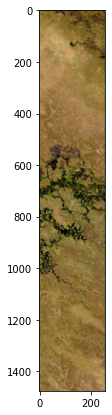

In [ ]:
view = spectral.imshow(X, rgb_bands, figsize=(7,7))

## Plot the Ground Truth with legend
* Ground Truth represents facts about the image using numbers, where each number represnts a class to which a particular pixel belongs to.
* Legend maps a class in the ground truth to a color code.
* This is provides a visualization of the labeled pixels in the dataset,

In [ ]:
def plotGroundTruth(gt, labels):
    values = np.unique(gt.ravel())
    plt.figure(figsize=(7,7))
    im = plt.imshow(gt,cmap='nipy_spectral',interpolation='none')
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0.15 , fontsize=14)
    plt.show()

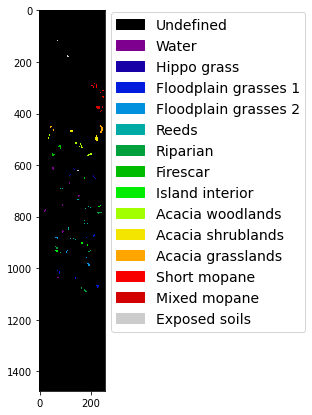

In [ ]:
plotGroundTruth(gt, classLabels)

## See the pixel vector
With hyperspectral Image, each pixel has an array of values from band-1 to band- N. The below code cell plots the spectral range of a particular pixel.

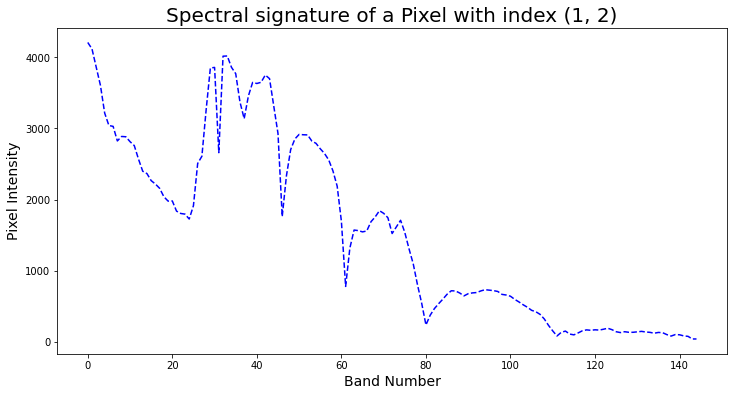

In [ ]:
plot_signature(X, 1, 2)

In [ ]:
X, sc = applyScaling(X)

## Graph to analyse the Variance ratio
* The variance ratio tells us how many number of components are needed from a PCA applied image to express the corresponding percentage of information.(More components represents more information)
* The below code cell provides a graphical representation of number of components to variance.
* We try to select the optimum number of components that can best express the information from the original image.

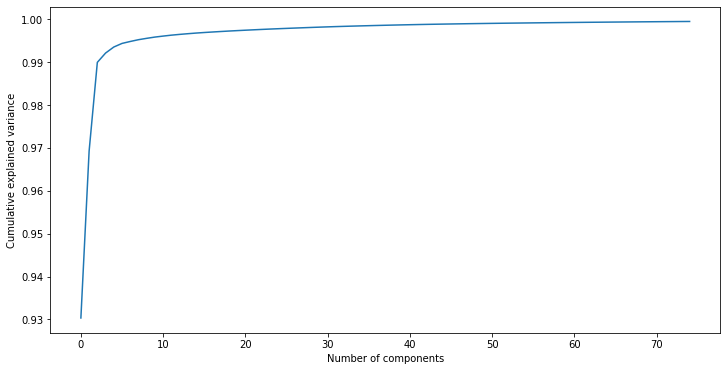

In [ ]:
plotExplainedVarienceRatio(X)

## Principal components 
Select the number of principal components based on the output of previous code cell
1. Indian Pines (IP) = 40 
1. University of Pavia (UP) = 15 
1. Salinas (SAL) = 15 
1. Kennedy Space Center (KSC) = 15
1. Botswana (BOT) = 40

In [ ]:
numPCA = 40

In [ ]:
print(f"Dimension of image before PCA = {X.shape}")
X, pca = applyPCA(X, numPCA)
print(f"Dimension of image after PCA = {X.shape}")

Dimension of image before PCA = (1476, 256, 145)
Dimension of image after PCA = (1476, 256, 40)


In [ ]:
X = padWithZeros(X, PATCH_SIZE)
print(f"Dimension of image after padding = {X.shape}")

Dimension of image after padding = (1486, 266, 40)


## Get the indices of the labelled pixels

In [ ]:
indexes, labels = getIndices(X, gt, PATCH_SIZE, True, True)
X_train, X_test, y_train, y_test = splitTrainTestSet(indexes, labels, trainRatio)

In [ ]:
print(f"Training Sample Size : {len(y_train)}\n\nTest Sample Size = {len(y_test)}")

val1, counts1 = np.unique(y_train, return_counts=True)
val2, counts2 = np.unique(y_test, return_counts=True)

print("\n\n--------------- TRAINING DATA  ---------------\t\t---------------  TESTING DATA  ---------------")
for i in range(len(val1)):
  print("{0} \t {1:30}  {2}".format(i, classLabels[i+1], counts1[i]) + "\t\t" + "{0} \t {1:30}  {2}".format(i, classLabels[i+1], counts2[i]) )

Training Sample Size : 2273

Test Sample Size = 975


--------------- TRAINING DATA  ---------------		---------------  TESTING DATA  ---------------
0 	 Water                           189		0 	 Water                           81
1 	 Hippo grass                     71		1 	 Hippo grass                     30
2 	 Floodplain grasses 1            176		2 	 Floodplain grasses 1            75
3 	 Floodplain grasses 2            150		3 	 Floodplain grasses 2            65
4 	 Reeds                           188		4 	 Reeds                           81
5 	 Riparian                        188		5 	 Riparian                        81
6 	 Firescar                        181		6 	 Firescar                        78
7 	 Island interior                 142		7 	 Island interior                 61
8 	 Acacia woodlands                220		8 	 Acacia woodlands                94
9 	 Acacia shrublands               174		9 	 Acacia shrublands               74
10 	 Acacia grasslands               213		10 	 Acaci

## We then pass the indexes to a generator
1. Data Generator combines the dataset and the indexes, and provides an iterable over the given dataset. 
1. The DataLoader enables single- or multi-process loading, customizing loading order and optional automatic batching and memory handling.

In [ ]:
training_generator = DataGenerator(X, gt, numOfClasses, X_train, PATCH_SIZE, BATCH_SIZE)
validation_generator = DataGenerator(X, gt, numOfClasses, X_test, PATCH_SIZE, BATCH_SIZE)

## Import relavent modules for Convolutional Neural Network

In [ ]:
import tensorflow as tf

import tensorflow.keras
import tensorflow.keras.layers as layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Flatten, Dense, add
from keras.layers.merge import concatenate
from tensorflow.keras.layers import Dropout, Input

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import initializers

## Define Mish activation function
Keras does not have an implementation for Mish activation, and hence we are defining it in the below code cell.
<br><br>
The Mish Activation is given by the expression below:
<br>
Mish(x) = x * tanh(log(1 + $e^{x}$)

In [ ]:
import tensorflow as tf
def mish(x):
	return tf.keras.layers.Lambda(lambda x: x*tf.tanh(tf.math.log(1+tf.exp(x))))(x)

## Define the Convolutional Neural Network
In the below code cell, we are defining all the layers of the proposed Convolutional Neural Network 

In [ ]:
# input layer
input = Input((PATCH_SIZE, PATCH_SIZE, numPCA, 1))

x = Conv3D(filters=64, kernel_size=(3, 3, 3), padding='valid', activation=mish,  )(input)
print(f"spectral-spatial : {x.shape}")

x = Conv3D(filters=64, kernel_size=(3, 3, 3), padding='valid', activation=mish,  )(x)
print(f"spectral-spatial : {x.shape}")

x = Conv3D(filters=64, kernel_size=(3, 3, 3), padding='valid', activation=mish,  )(x)
print(f"spectral-spatial : {x.shape}")

# Spatial feature extraction sub network
x2 = Conv3D(filters=128, kernel_size=(3, 3, 1), padding='same',activation=mish,  )(x)
print(f"spatial : {x2.shape}")

x2 = Conv3D(filters=128, kernel_size=(3, 3, 1), padding='valid',activation=mish,  )(x2)
print(f"spatial : {x2.shape}")

x2 = Conv3D(filters=128, kernel_size=(3, 3, 1), padding='valid',  activation=mish,  )(x2)
print(f"spatial : {x2.shape}")

# Spectral feature extraction sub network
xs = x.shape
x3 = Conv3D(filters=128, kernel_size=(xs[1], xs[2], 3), padding='valid', activation=mish,  )(x)
print(f"spectral : {x3.shape}")

x3 = Conv3D(filters=128, kernel_size=(1, 1, 3), padding='valid', activation=mish,  )(x3)
print(f"spectral : {x3.shape}")

x3 = Conv3D(filters=128, kernel_size=(1, 1, 3), padding='valid', activation=mish,  )(x3)
print(f"spectral : {x3.shape}")

x2 = Flatten()(x2)
x3 = Flatten()(x3)

x = concatenate([ x2, x3], axis=-1)
print(x.shape[1])

x = Dense(units=1024,  activation=mish,  )(x)
x = Dropout(0.4)(x)

x = Dense(units=1024, activation=mish,  )(x)
x = Dropout(0.4)(x)

x = Dense(units=512, activation=mish,  )(x)
x = Dropout(0.4)(x)

x = Dense(units=512, activation=mish,  )(x)
x = Dropout(0.4)(x)

output = Dense(units=numOfClasses, activation='softmax',  )(x)

spectral-spatial : (None, 9, 9, 38, 64)
spectral-spatial : (None, 7, 7, 36, 64)
spectral-spatial : (None, 5, 5, 34, 64)
spatial : (None, 5, 5, 34, 128)
spatial : (None, 3, 3, 34, 128)
spatial : (None, 1, 1, 34, 128)
spectral : (None, 1, 1, 32, 128)
spectral : (None, 1, 1, 30, 128)
spectral : (None, 1, 1, 28, 128)
7936


In [ ]:
# define the model with input layer and output layer
model = Model(inputs = input, outputs = output)

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 11, 11, 40,  0                                            
__________________________________________________________________________________________________
conv3d_87 (Conv3D)              (None, 9, 9, 38, 64) 1792        input_11[0][0]                   
__________________________________________________________________________________________________
dropout_58 (Dropout)            (None, 9, 9, 38, 64) 0           conv3d_87[0][0]                  
__________________________________________________________________________________________________
conv3d_88 (Conv3D)              (None, 7, 7, 36, 64) 110656      dropout_58[0][0]                 
___________________________________________________________________________________________

## Instantiating the optimizer and loss function
* The loss function calculates the loss occured in each training cycle.
* The optimizer takes the output of the loss function and optimizes the weights in the network
* This is repeated at the end of each training cycle

In [ ]:
#hyperparameters
adam = Adam(learning_rate=0.0001, decay=1e-05)
loss = CategoricalCrossentropy()
model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])

In [ ]:
filepath = NAME + "-best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Start the training

In [ ]:
import time

start = time.time()

history = model.fit(training_generator, validation_data=validation_generator, epochs = 100, verbose=1, callbacks = callbacks_list)

print("--- %s seconds ---" % (time.time() - start))

Epoch 1/100
18/18 [==============================] - 8s 410ms/step - loss: 2.5747 - accuracy: 0.4316 - val_loss: 2.2429 - val_accuracy: 0.5959

Epoch 00001: val_accuracy improved from -inf to 0.59590, saving model to BOT-best-model.hdf5
Epoch 2/100
18/18 [==============================] - 4s 241ms/step - loss: 1.1251 - accuracy: 0.6938 - val_loss: 0.1596 - val_accuracy: 0.9528

Epoch 00002: val_accuracy improved from 0.59590 to 0.95282, saving model to BOT-best-model.hdf5
Epoch 3/100
18/18 [==============================] - 4s 238ms/step - loss: 0.1941 - accuracy: 0.9393 - val_loss: 0.0385 - val_accuracy: 0.9887

Epoch 00003: val_accuracy improved from 0.95282 to 0.98872, saving model to BOT-best-model.hdf5
Epoch 4/100
18/18 [==============================] - 4s 239ms/step - loss: 0.0625 - accuracy: 0.9828 - val_loss: 0.0123 - val_accuracy: 0.9979

Epoch 00004: val_accuracy improved from 0.98872 to 0.99795, saving model to BOT-best-model.hdf5
Epoch 5/100
18/18 [========================

KeyboardInterrupt: ignored

In [ ]:
# Download the weights for later use
if DOWNLOAD_WEIGHTS == True:
    from google.colab import files
    files.download(filepath)

# Get the indexes of the whole image
1. Shuffle is set to False so that we dont get scrambled results

In [ ]:
indices, labels = getIndices(X, gt, PATCH_SIZE, False, True)
generator = DataGenerator(X, gt, numOfClasses, indices, PATCH_SIZE, BATCH_SIZE, False)

In [ ]:
# load best weights for the model
filepath = NAME + "-best-model.hdf5"

model.load_weights(filepath)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
y_pred = model.predict(generator, batch_size=256)

In [ ]:
print(f"Total number of predictions = {y_pred.shape}")

Total number of predictions = (377856, 14)


In [ ]:
height = gt.shape[0]
width = gt.shape[1]

full_map = np.argmax(y_pred, axis=1)
full_map = full_map.reshape(height, width)

full_map = full_map + 1

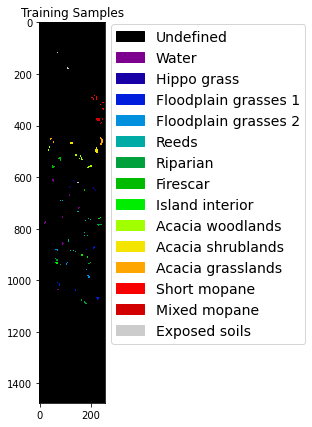

In [ ]:
plotGroundTruth(gt, classLabels)

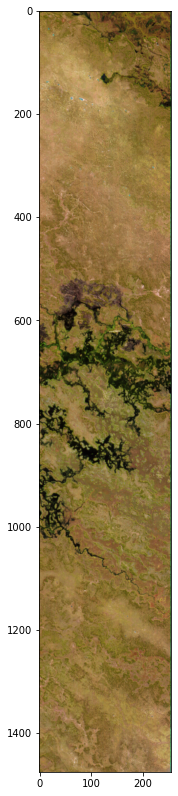

In [ ]:
image, gt, classLabels, rgb_bands, spatial_resolution = loadDataSet(NAME)
view = spectral.imshow(image, rgb_bands, figsize=(14,14))
spectral.save_rgb(NAME + '_rgb.jpg', X, rgb_bands)


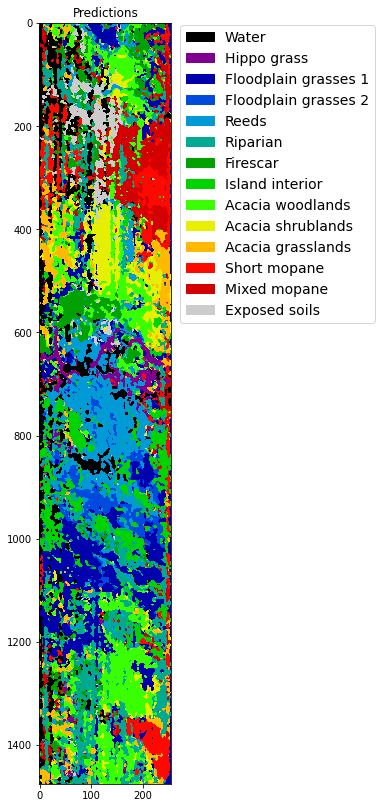

In [ ]:
values = np.unique(full_map.ravel())

plt.figure(figsize=(14,14))
im = plt.imshow(full_map, cmap='nipy_spectral',interpolation='none')

colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=classLabels[i+1]) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0.15 , fontsize=14)
plt.title("Predictions")
plt.savefig(NAME + "_predictions.jpg")
plt.show()

In [ ]:
_, counts3 = np.unique(full_map, return_counts=True)
total_pixels = height * width
print("---------   Percentage Distribution   ---------\n")
for i in range(numOfClasses):
  print("  {0} \t {1:30}  {2:.3f} %".format(i+1, classLabels[i+1], (counts3[i]/total_pixels)*100))

---------   Percentage Distribution   ---------

  1 	 Water                           9.587 %
  2 	 Hippo grass                     3.300 %
  3 	 Floodplain grasses 1            13.920 %
  4 	 Floodplain grasses 2            3.195 %
  5 	 Reeds                           9.082 %
  6 	 Riparian                        8.492 %
  7 	 Firescar                        3.788 %
  8 	 Island interior                 7.027 %
  9 	 Acacia woodlands                13.757 %
  10 	 Acacia shrublands               6.940 %
  11 	 Acacia grasslands               5.546 %
  12 	 Short mopane                    6.150 %
  13 	 Mixed mopane                    5.465 %
  14 	 Exposed soils                   3.752 %
